# Time series analysis of historical (1981-2021) weather data from Tokyo, Japan as well as time series forecasting of maximum and average temperatures using the xgboost module.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import statistics

from datetime import datetime
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (15,5)

In [58]:
df.head()

,Date,Average pressure,Sea level pressure,Rainfall,Max rainfall (1 hour),Max rainfall (10 mins),Ave temp,Max temp,Min temp,Ave humidity,Min humidity,Ave wind speed,Hours of sunlight,Snowfall,Max snow cover,Gust x,Gust y,Max x,Max y
0,1981-01-01,1014.7,1019.2,0.0,0.0,0.0,5.0,8.9,1.3,51.0,31.0,2.5,8.7,0.0,0.0,6.744321,-2.793589,4.527010,-1.875149
1,1981-01-02,999.5,1003.8,2.0,2.0,1.0,4.6,7.5,1.9,81.0,42.0,2.6,3.5,0.0,0.0,-7.424621,-7.424621,-4.384062,-4.384062
2,1981-01-03,998.1,1002.5,0.0,0.0,0.0,5.1,9.0,2.2,40.0,19.0,4.8,8.9,0.0,0.0,-9.545942,-9.545942,-4.808326,-4.808326
3,1981-01-04,1004.8,1009.3,0.0,0.0,0.0,4.4,9.6,-0.6,47.0,32.0,3.8,8.6,0.0,0.0,15.613564,-6.467350,10.162675,-4.209518
4,1981-01-05,1006.5,1010.9,0.0,0.0,0.0,4.1,8.4,0.0,46.0,28.0,3.1,7.9,0.0,0.0,10.717003,-4.439128,6.929096,-2.870126


In [59]:
df = df[['Date', 'Rainfall','Ave temp','Max temp','Min temp','Snowfall','Max snow cover']]
df

,Date,Rainfall,Ave temp,Max temp,Min temp,Snowfall,Max snow cover
0,1981-01-01,0.0,5.0,8.9,1.3,0.0,0.0
1,1981-01-02,2.0,4.6,7.5,1.9,0.0,0.0
2,1981-01-03,0.0,5.1,9.0,2.2,0.0,0.0
3,1981-01-04,0.0,4.4,9.6,-0.6,0.0,0.0
4,1981-01-05,0.0,4.1,8.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...
14875,2021-09-23,0.0,26.6,31.7,22.9,0.0,0.0
14876,2021-09-24,0.0,25.4,30.6,21.2,0.0,0.0
14877,2021-09-25,0.0,22.1,24.5,20.3,0.0,0.0
14878,2021-09-26,0.0,19.9,21.3,18.2,0.0,0.0


In [60]:
df['Date'] = pd.to_datetime(df['Date'])
date_index = df['Date']
df.insert(loc=0, column='Date Index', value=date_index)
df = df.set_index('Date Index')
df

,Date,Rainfall,Ave temp,Max temp,Min temp,Snowfall,Max snow cover
Date Index,,,,,,,
1981-01-01,1981-01-01,0.0,5.0,8.9,1.3,0.0,0.0
1981-01-02,1981-01-02,2.0,4.6,7.5,1.9,0.0,0.0
1981-01-03,1981-01-03,0.0,5.1,9.0,2.2,0.0,0.0
1981-01-04,1981-01-04,0.0,4.4,9.6,-0.6,0.0,0.0
1981-01-05,1981-01-05,0.0,4.1,8.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2021-09-23,2021-09-23,0.0,26.6,31.7,22.9,0.0,0.0
2021-09-24,2021-09-24,0.0,25.4,30.6,21.2,0.0,0.0
2021-09-25,2021-09-25,0.0,22.1,24.5,20.3,0.0,0.0


In [61]:
#create time series features
def create_features(df):
    df['Week'] = df.index.isocalendar().week
    df['Month'] =  df.index.month
    df['Quarter'] = df.index.quarter
    df['Year'] = df.index.year
    return df

In [62]:
df = create_features(df)
df

,Date,Rainfall,Ave temp,Max temp,Min temp,Snowfall,Max snow cover,Week,Month,Quarter,Year
Date Index,,,,,,,,,,,
1981-01-01,1981-01-01,0.0,5.0,8.9,1.3,0.0,0.0,1,1,1,1981
1981-01-02,1981-01-02,2.0,4.6,7.5,1.9,0.0,0.0,1,1,1,1981
1981-01-03,1981-01-03,0.0,5.1,9.0,2.2,0.0,0.0,1,1,1,1981
1981-01-04,1981-01-04,0.0,4.4,9.6,-0.6,0.0,0.0,1,1,1,1981
1981-01-05,1981-01-05,0.0,4.1,8.4,0.0,0.0,0.0,2,1,1,1981
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,2021-09-23,0.0,26.6,31.7,22.9,0.0,0.0,38,9,3,2021
2021-09-24,2021-09-24,0.0,25.4,30.6,21.2,0.0,0.0,38,9,3,2021
2021-09-25,2021-09-25,0.0,22.1,24.5,20.3,0.0,0.0,38,9,3,2021


In [63]:
# daily temperature range
df['Temp variation'] = df.apply(lambda x: x['Max temp'] - x['Min temp'], axis=1)
df

,Date,Rainfall,Ave temp,Max temp,Min temp,Snowfall,Max snow cover,Week,Month,Quarter,Year,Temp variation
Date Index,,,,,,,,,,,,
1981-01-01,1981-01-01,0.0,5.0,8.9,1.3,0.0,0.0,1,1,1,1981,7.6
1981-01-02,1981-01-02,2.0,4.6,7.5,1.9,0.0,0.0,1,1,1,1981,5.6
1981-01-03,1981-01-03,0.0,5.1,9.0,2.2,0.0,0.0,1,1,1,1981,6.8
1981-01-04,1981-01-04,0.0,4.4,9.6,-0.6,0.0,0.0,1,1,1,1981,10.2
1981-01-05,1981-01-05,0.0,4.1,8.4,0.0,0.0,0.0,2,1,1,1981,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,2021-09-23,0.0,26.6,31.7,22.9,0.0,0.0,38,9,3,2021,8.8
2021-09-24,2021-09-24,0.0,25.4,30.6,21.2,0.0,0.0,38,9,3,2021,9.4
2021-09-25,2021-09-25,0.0,22.1,24.5,20.3,0.0,0.0,38,9,3,2021,4.2


# Historical temperature analysis (1981-2021)

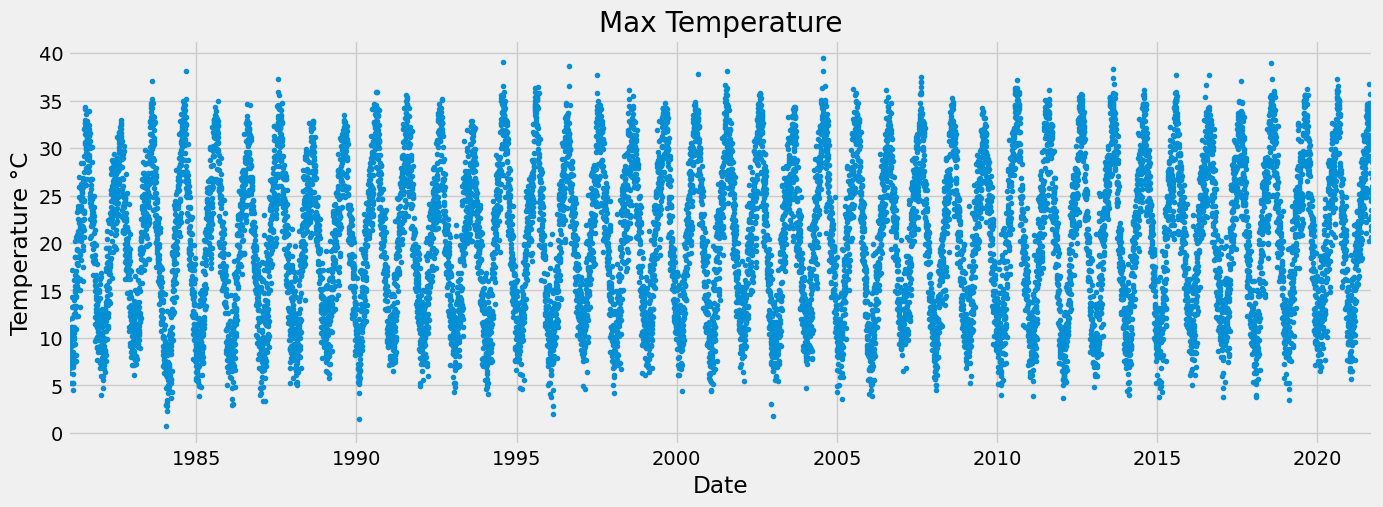

In [67]:
df.plot(x='Date',y='Max temp',style='.', color=color_pal[0], ylabel='Temperature °C')
plt.title('Max Temperature')
plt.legend('', frameon=False)

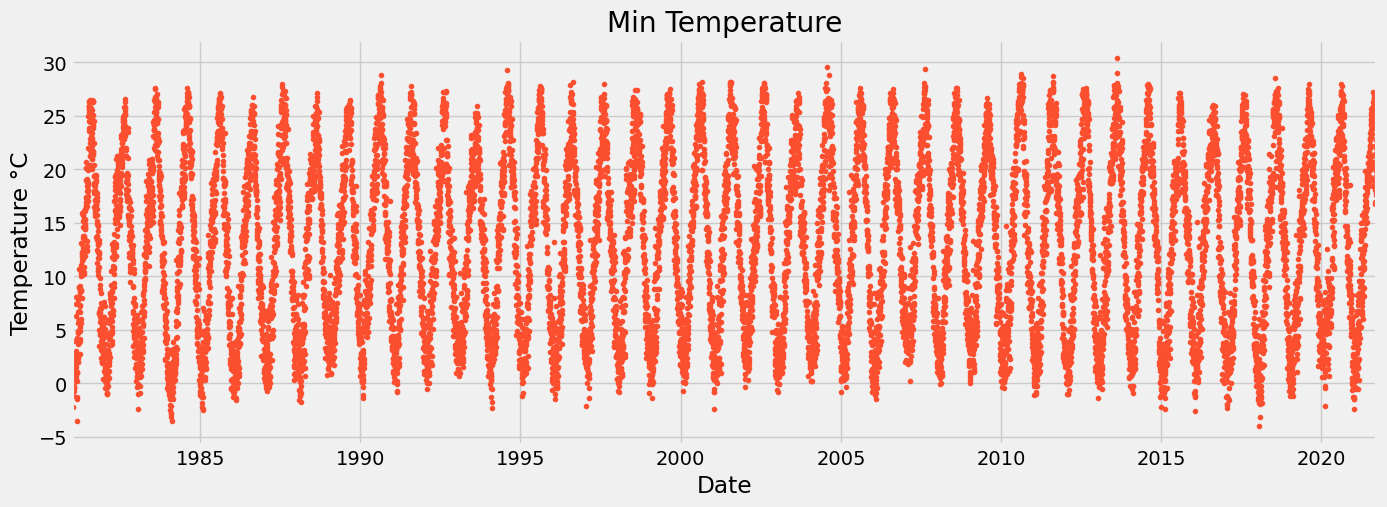

In [68]:
df.plot(x='Date',y='Min temp',style='.', color=color_pal[1], ylabel='Temperature °C')
plt.title('Min Temperature')
plt.legend('', frameon=False)

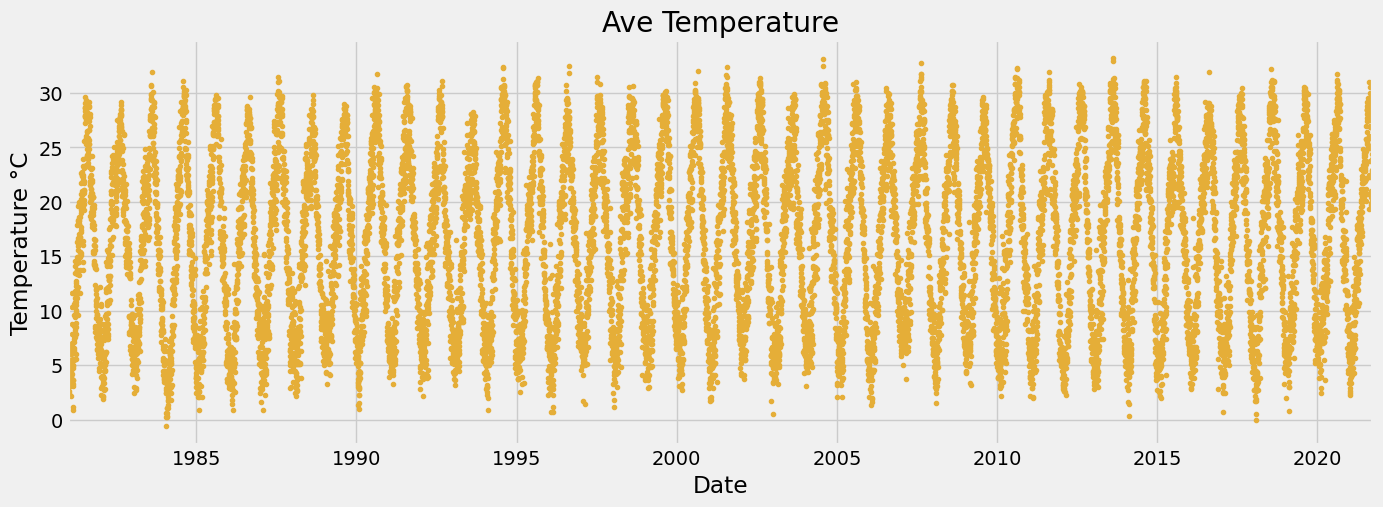

In [69]:
df.plot(x='Date',y='Ave temp',style='.', color=color_pal[2], ylabel='Temperature °C')
plt.title('Ave Temperature')
plt.legend('', frameon=False)

# Visualizing temperature year by year

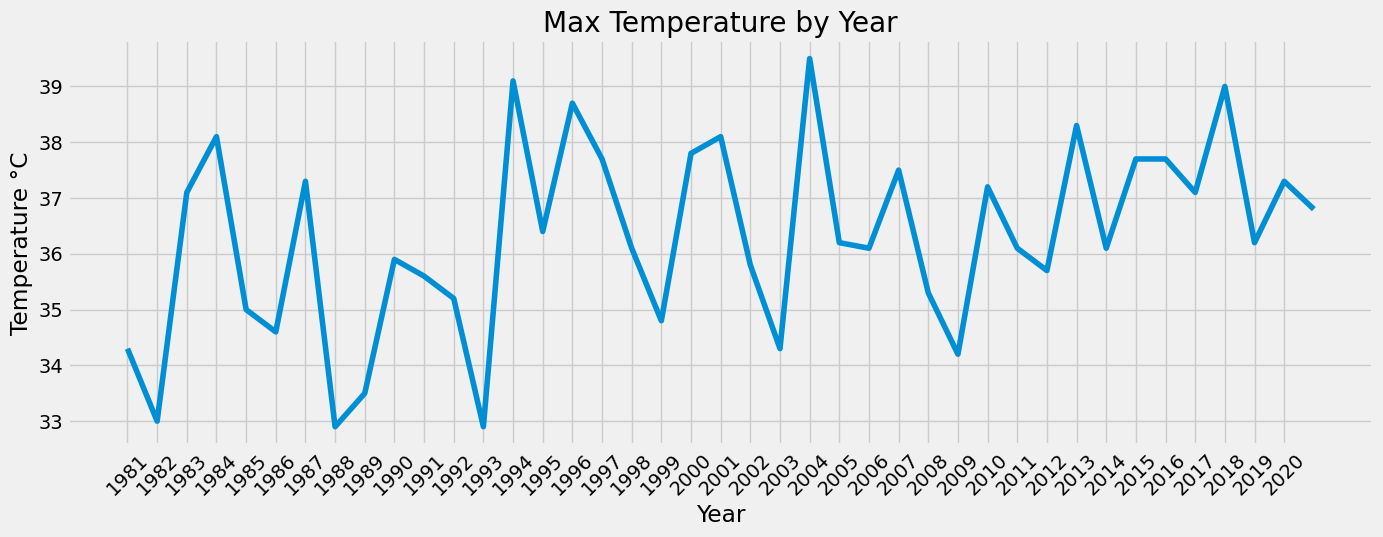

In [70]:
max_T_yr = df.groupby('Year')[['Max temp']].max()
max_T_yr.plot(style='-', color=color_pal[0], ylabel='Temperature °C', rot=45)
plt.xticks(np.arange(1981,2021,1))
plt.title('Max Temperature by Year')
plt.legend('', frameon=False)

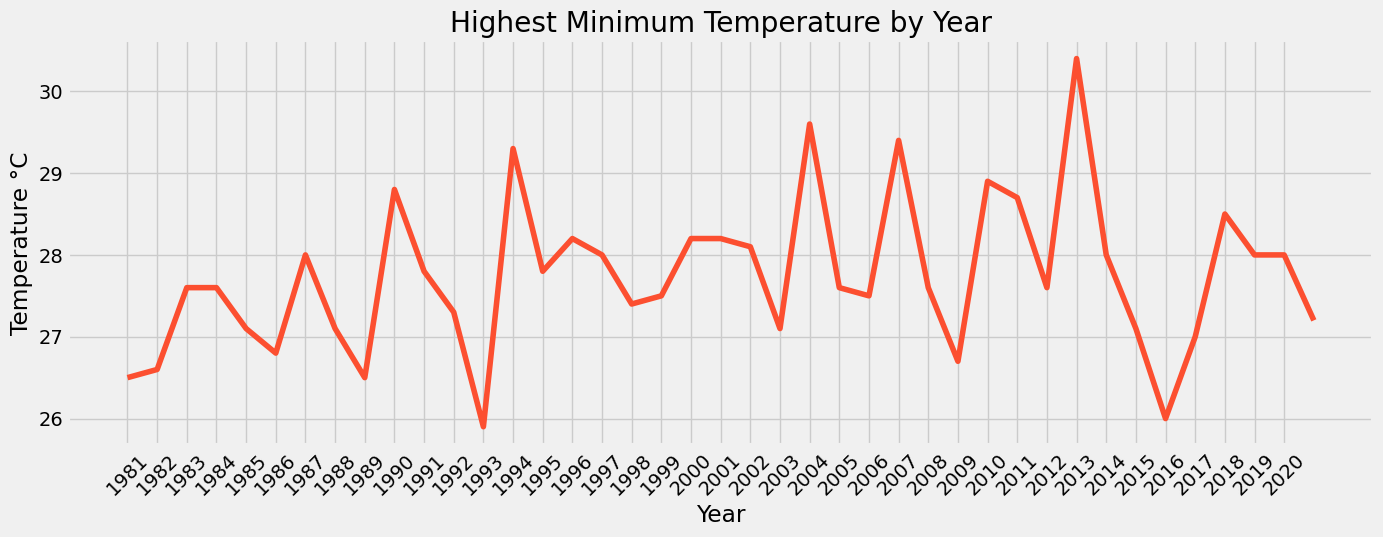

In [71]:
ave_T_yr = df.groupby('Year')[['Min temp']].max()
ave_T_yr.plot(style='-', color=color_pal[1], ylabel='Temperature °C', rot=45)
plt.xticks(np.arange(1981,2021,1))
plt.title('Highest Minimum Temperature by Year')
plt.legend('', frameon=False)

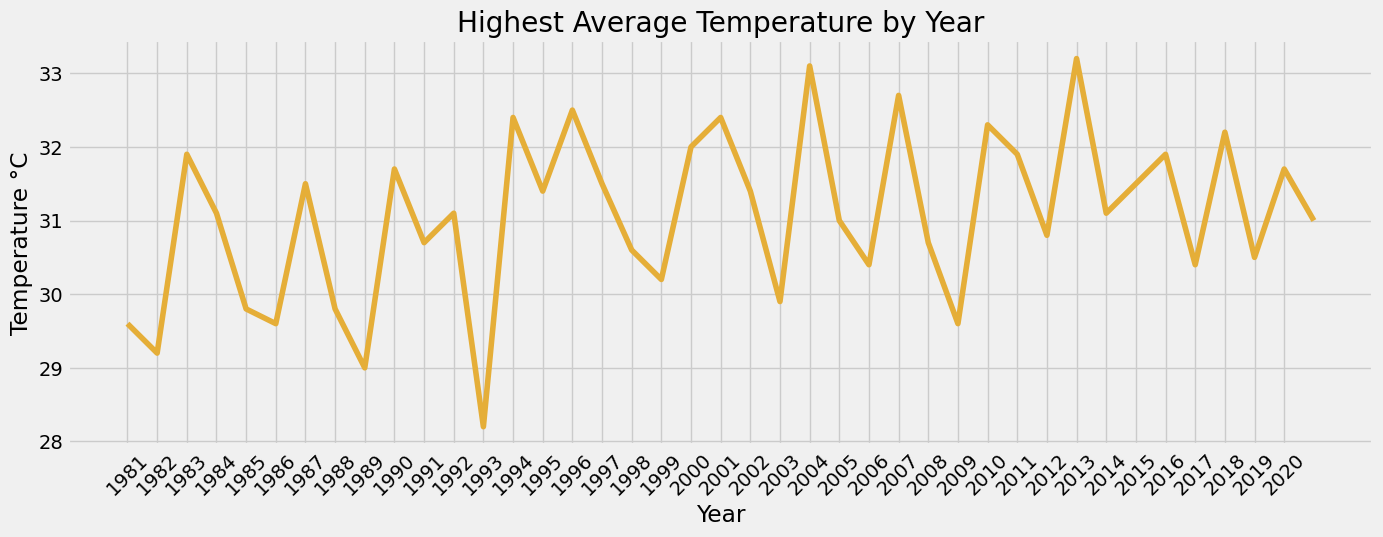

In [72]:
ave_T_yr = df.groupby('Year')[['Ave temp']].max()
ave_T_yr.plot(style='-', color=color_pal[2], ylabel='Temperature °C', rot=45)
plt.xticks(np.arange(1981,2021,1))
plt.title('Highest Average Temperature by Year')
plt.legend('', frameon=False)

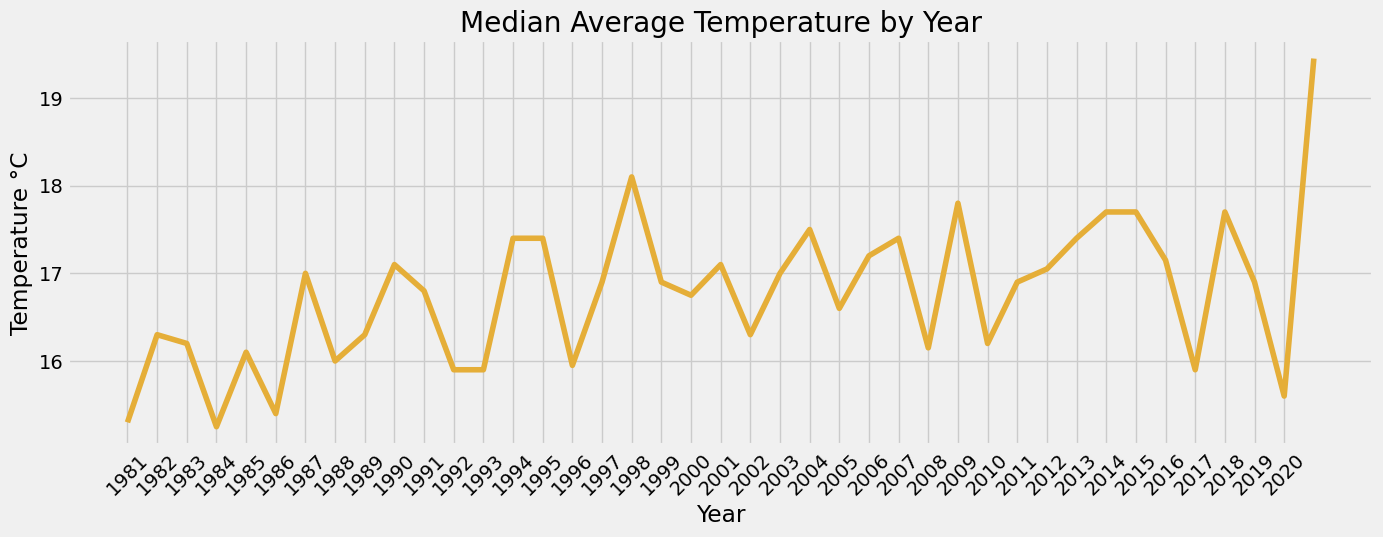

In [73]:
#median averagae temp by year
median_ave_T_yr = df.groupby('Year')[['Ave temp']].median()
median_ave_T_yr.plot(style='-', color=color_pal[2], ylabel='Temperature °C', rot=45)
plt.xticks(np.arange(1981,2021,1))
plt.title('Median Average Temperature by Year')
plt.legend('', frameon=False)

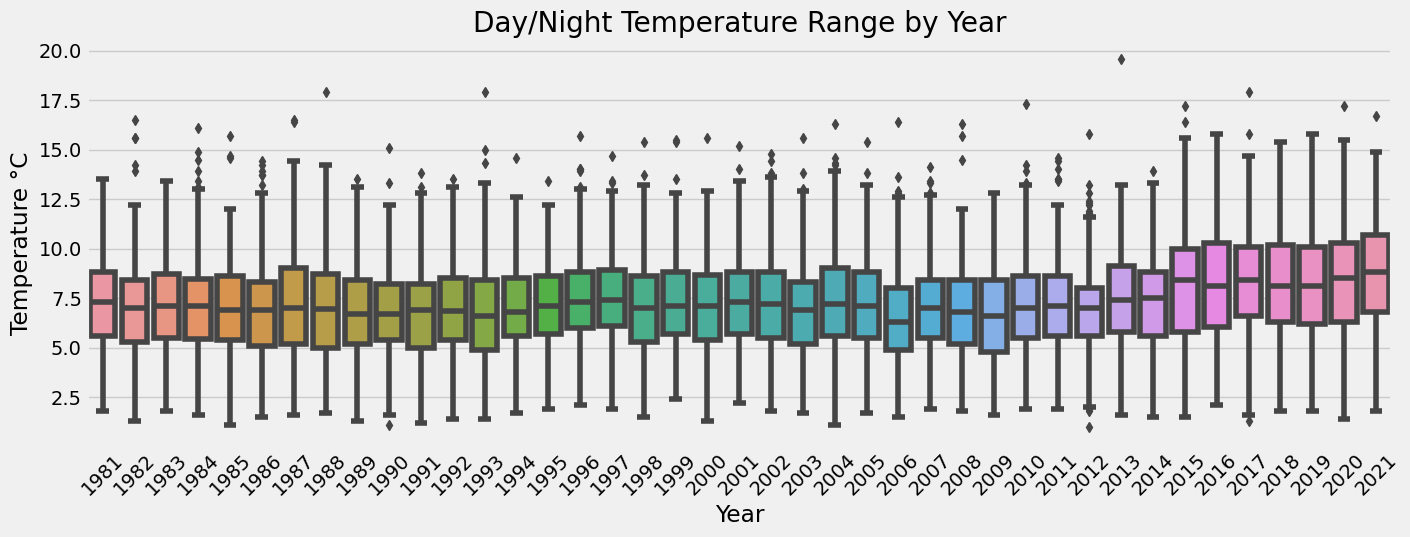

In [74]:
sns.boxplot(data=df,x='Year', y='Temp variation')
plt.title('Day/Night Temperature Range by Year')
plt.ylabel('Temperature °C')
plt.xticks(rotation=45)
plt.show()

# Max Temperature Outlier Analysis

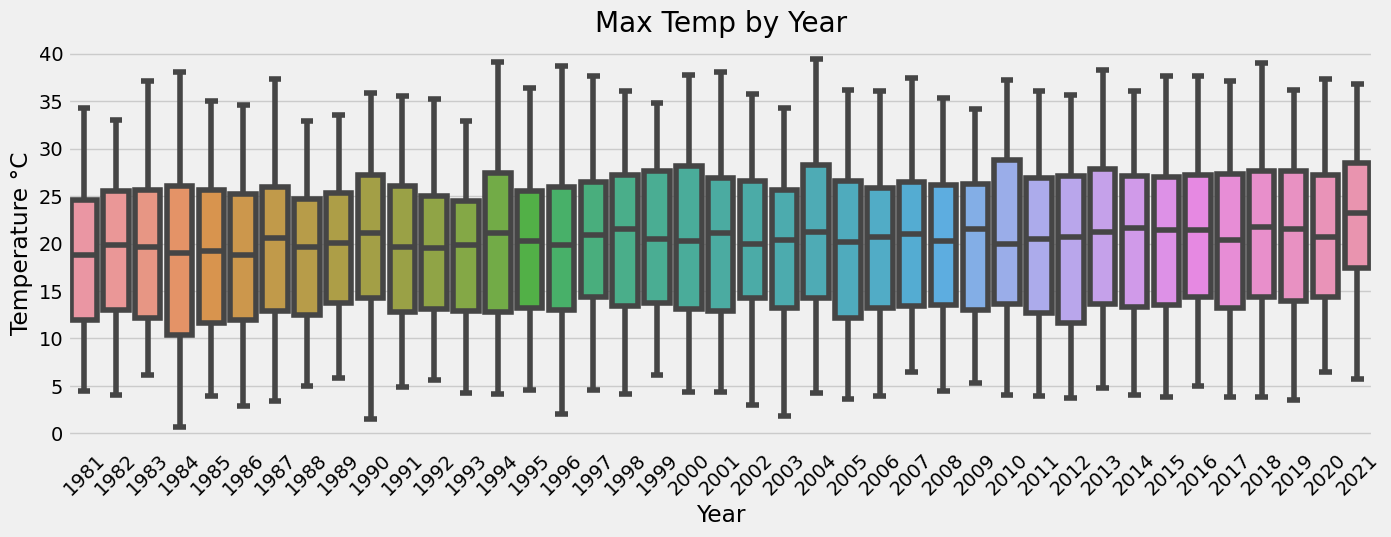

In [80]:
sns.boxplot(data=df,x='Year', y='Max temp')
plt.title('Max Temp by Year')
plt.ylabel('Temperature °C')
plt.xticks(rotation=45)
plt.show()

Text(0.5, 0, 'Temperature')

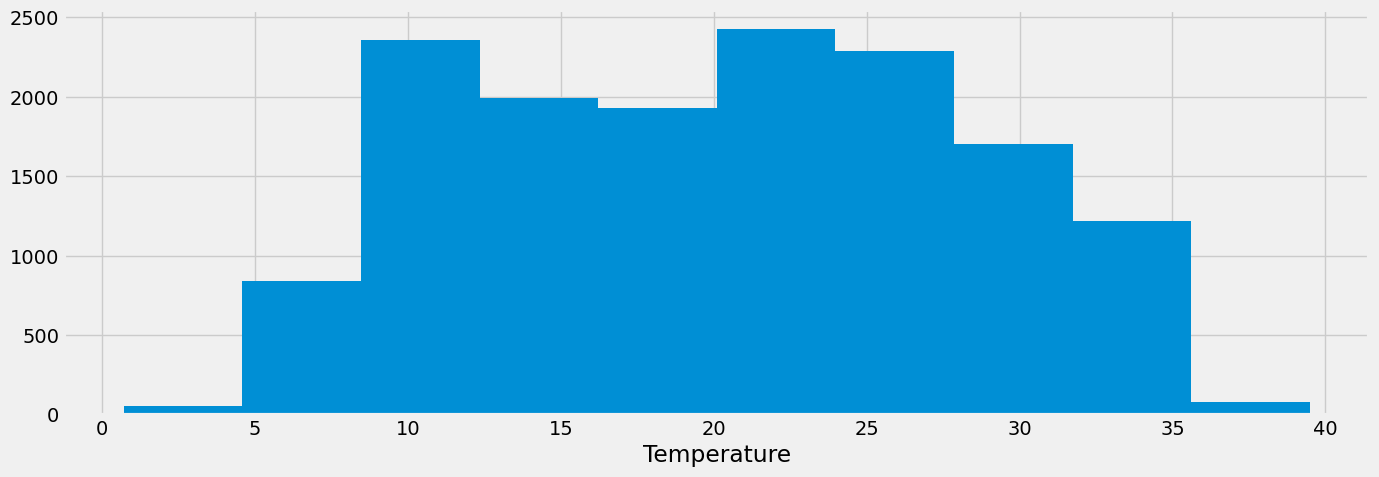

In [81]:
df['Max temp'].hist()
plt.xlabel('Temperature')

# Max Temperature Train/Test Split

In [82]:
train = df.loc[df.index < '2018-12-31']
test = df.loc[df.index > '2019-01-01']
train

,Date,Rainfall,Ave temp,Max temp,Min temp,Snowfall,Max snow cover,Week,Month,Quarter,Year,Temp variation
Date Index,,,,,,,,,,,,
1981-01-01,1981-01-01,0.0,5.0,8.9,1.3,0.0,0.0,1,1,1,1981,7.6
1981-01-02,1981-01-02,2.0,4.6,7.5,1.9,0.0,0.0,1,1,1,1981,5.6
1981-01-03,1981-01-03,0.0,5.1,9.0,2.2,0.0,0.0,1,1,1,1981,6.8
1981-01-04,1981-01-04,0.0,4.4,9.6,-0.6,0.0,0.0,1,1,1,1981,10.2
1981-01-05,1981-01-05,0.0,4.1,8.4,0.0,0.0,0.0,2,1,1,1981,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-26,2018-12-26,0.0,7.3,11.7,1.2,0.0,0.0,52,12,4,2018,10.5
2018-12-27,2018-12-27,0.0,9.0,13.2,4.9,0.0,0.0,52,12,4,2018,8.3
2018-12-28,2018-12-28,0.0,4.8,8.4,1.8,0.0,0.0,52,12,4,2018,6.6


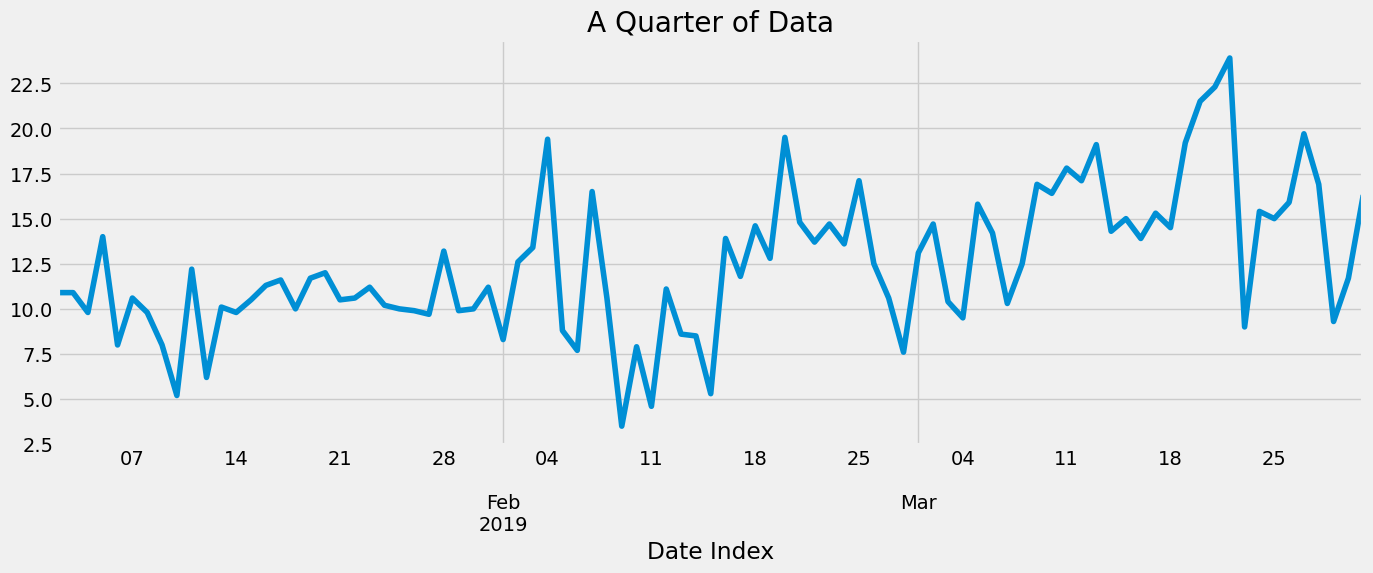

In [83]:
#plotting a quarter of max temp data
df.loc[(df.index > '2019-01-01') & (df.index < '2019-04-01')][['Max temp']].plot(title='A Quarter of Data')
plt.legend('', frameon=False)
plt.show()

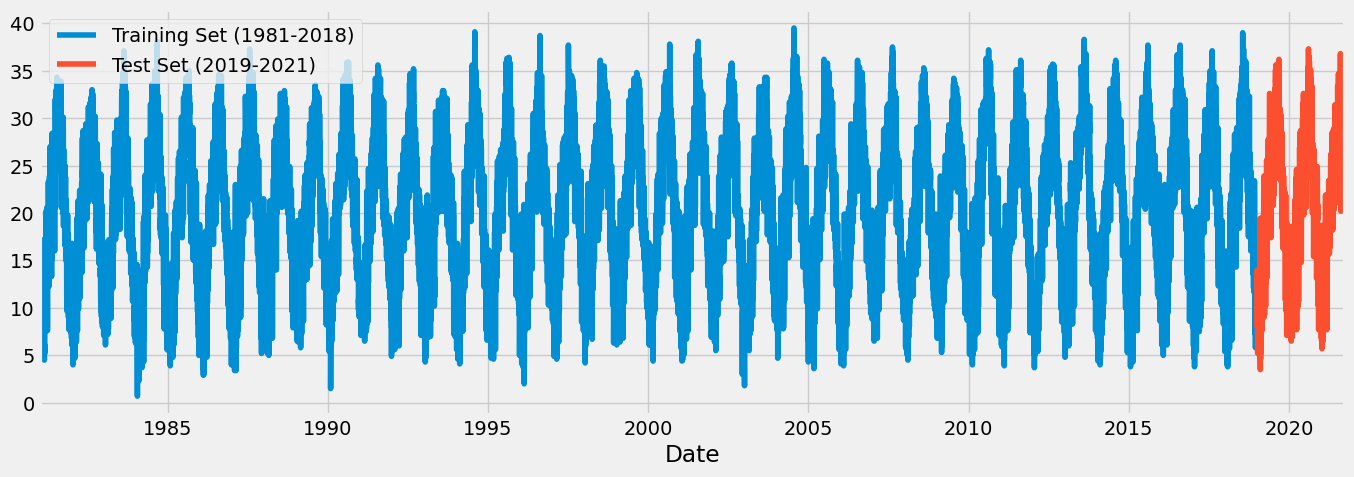

In [84]:
fig, ax = plt.subplots()
train.plot(ax=ax, x='Date', y='Max temp')
test.plot(ax=ax, x='Date', y='Max temp')
ax.legend(['Training Set (1981-2018)','Test Set (2019-2021)'])
plt.show()

Text(0.5, 1.0, 'Max Temperatures by Month')

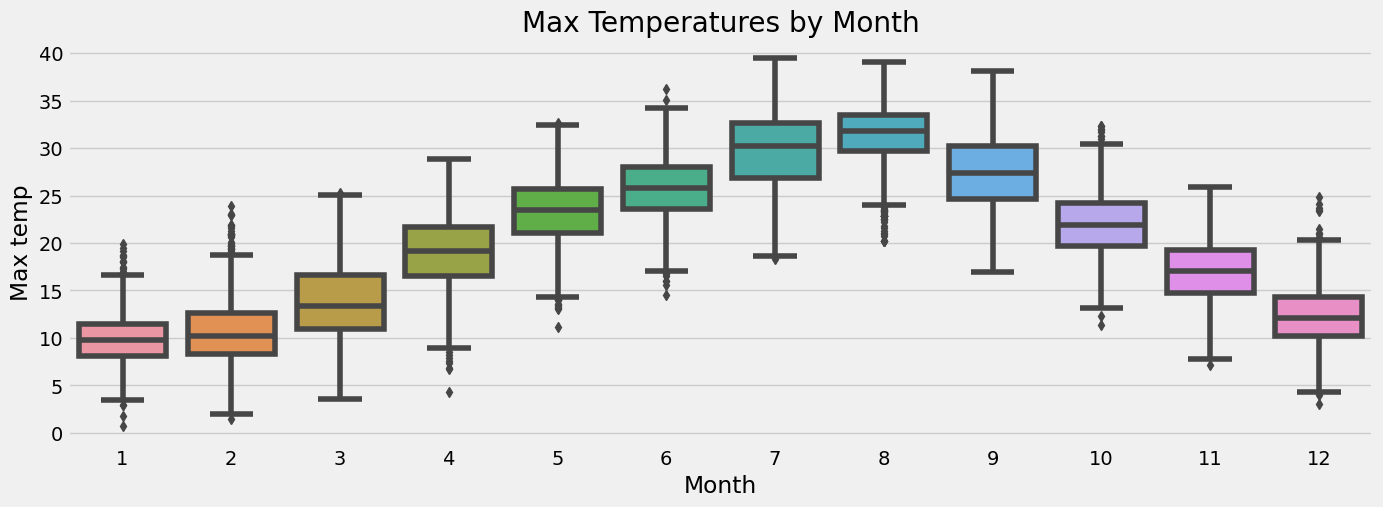

In [85]:
sns.boxplot(data=df, x='Month', y='Max temp')
plt.title('Max Temperatures by Month')

<Axes: >

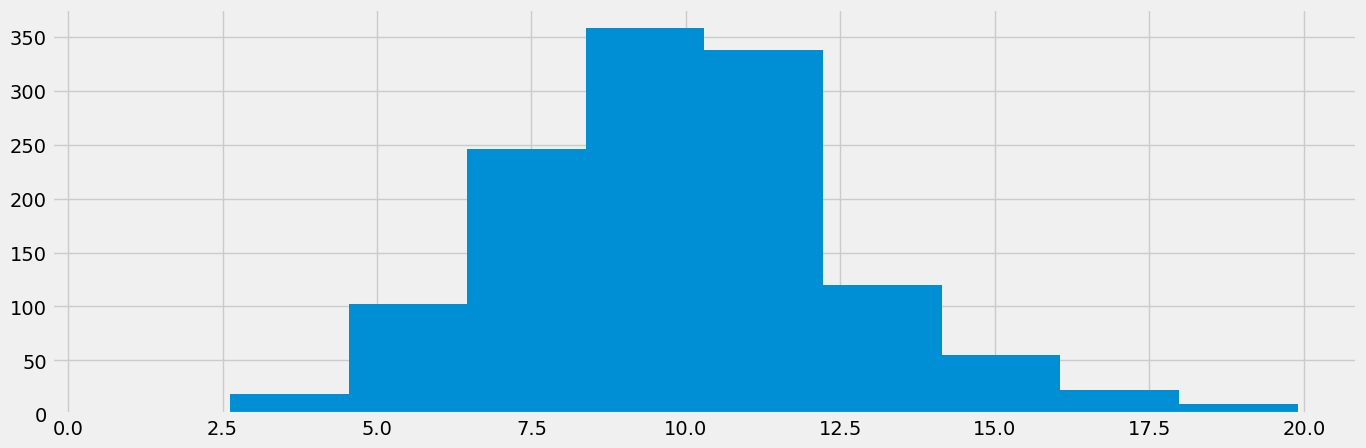

In [86]:
df.query('Month == 1')['Max temp'].hist()

# Regression model for max temp (without cross-validation and lag features)

In [88]:
FEATURES = ['Year','Quarter','Month', 'Week']
TARGET = 'Max temp'

X_train = train[FEATURES]
Y_train = train[TARGET]

X_test = test[FEATURES]
Y_test = test[TARGET]

reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate=0.01)
reg.fit(X_train, Y_train_MAX, 
       eval_set=[(X_train, Y_train), (X_test, Y_test)],
       verbose=50)

[0]	validation_0-rmse:7.91015	validation_1-rmse:7.87086
[50]	validation_0-rmse:5.41133	validation_1-rmse:5.49916
[100]	validation_0-rmse:4.10934	validation_1-rmse:4.32983
[150]	validation_0-rmse:3.49269	validation_1-rmse:3.83218
[200]	validation_0-rmse:3.22177	validation_1-rmse:3.67797
[250]	validation_0-rmse:3.10163	validation_1-rmse:3.65002
[295]	validation_0-rmse:3.04721	validation_1-rmse:3.67189


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Max Temp Feature Importances

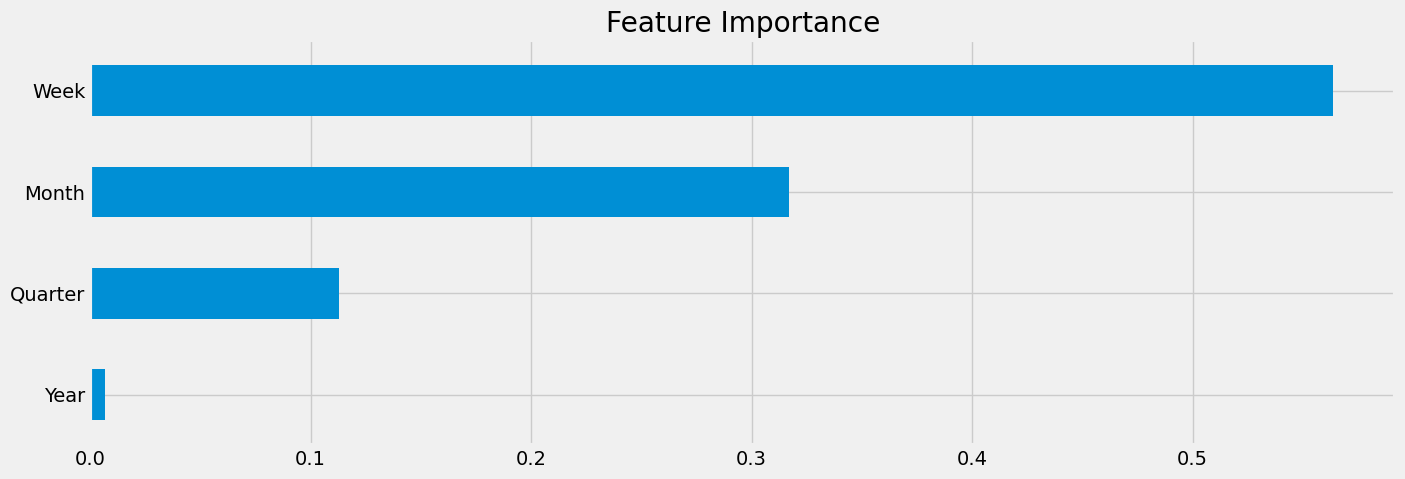

In [91]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend('', frameon=False)
plt.show()

# Forecast on max temp test data - validation set

In [92]:
test['Prediction_MAX'] = reg.predict(X_test)
df = df.merge(test['Prediction_MAX'], how='left', left_index=True, right_index=True)
df

C:\Users\Mia\AppData\Local\Temp\ipykernel_7960\1022910206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction_MAX'] = reg.predict(X_test)


,Date,Rainfall,Ave temp,Max temp,Min temp,Snowfall,Max snow cover,Week,Month,Quarter,Year,Temp variation,Prediction_MAX
Date Index,,,,,,,,,,,,,
1981-01-01,1981-01-01,0.0,5.0,8.9,1.3,0.0,0.0,1,1,1,1981,7.6,NaN
1981-01-02,1981-01-02,2.0,4.6,7.5,1.9,0.0,0.0,1,1,1,1981,5.6,NaN
1981-01-03,1981-01-03,0.0,5.1,9.0,2.2,0.0,0.0,1,1,1,1981,6.8,NaN
1981-01-04,1981-01-04,0.0,4.4,9.6,-0.6,0.0,0.0,1,1,1,1981,10.2,NaN
1981-01-05,1981-01-05,0.0,4.1,8.4,0.0,0.0,0.0,2,1,1,1981,8.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,2021-09-23,0.0,26.6,31.7,22.9,0.0,0.0,38,9,3,2021,8.8,26.104244
2021-09-24,2021-09-24,0.0,25.4,30.6,21.2,0.0,0.0,38,9,3,2021,9.4,26.104244
2021-09-25,2021-09-25,0.0,22.1,24.5,20.3,0.0,0.0,38,9,3,2021,4.2,26.104244


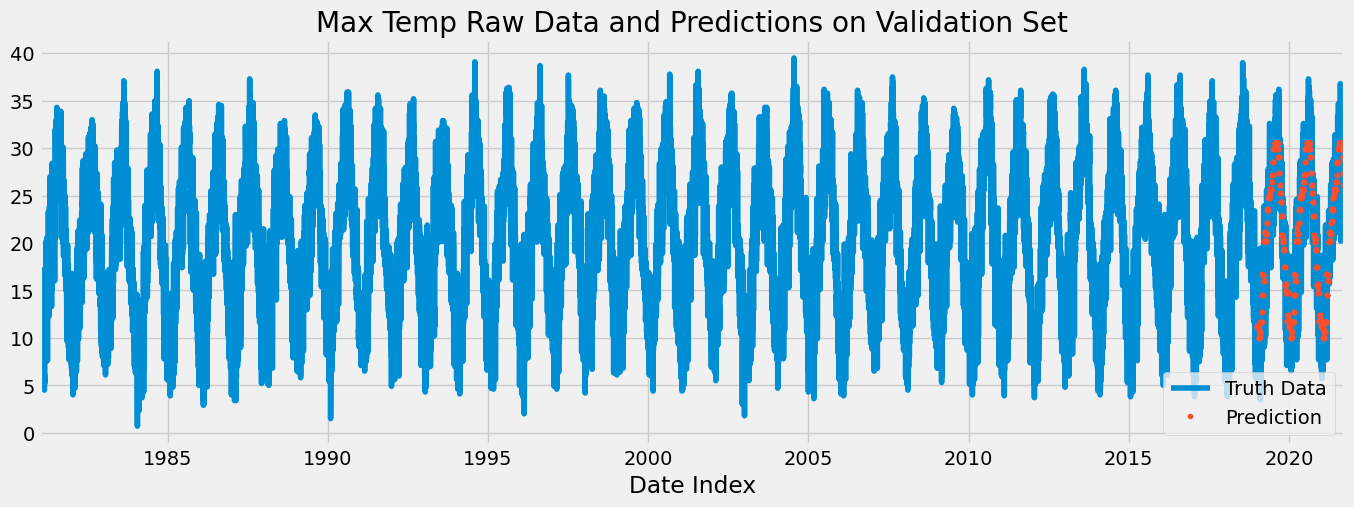

In [104]:
ax = df[['Max temp']].plot()
df['Prediction_MAX'].plot(ax=ax, style='.')
plt.legend(['Truth Data','Prediction'])
ax.set_title('Max Temp Raw Data and Predictions on Validation Set')
plt.show()

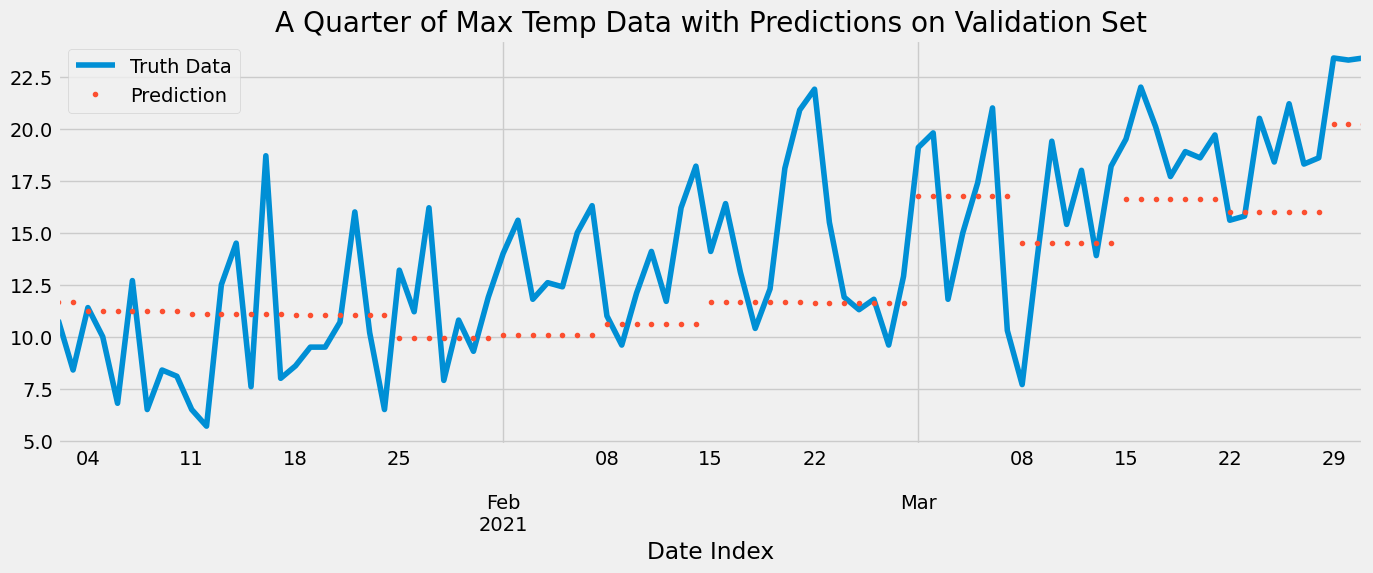

In [119]:
#plotting max temp data over a quarter w/ predictions
ax = df.loc[(df.index > '2021-01-01') & (df.index < '2021-04-01')]['Max temp']\
        .plot(title='A Quarter of Max Temp Data with Predictions on Validation Set', style='-')
df.loc[(df.index > '2021-01-01') & (df.index < '2021-04-01')]['Prediction_MAX'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Regression model training with cross-validation and time lag features - Max Temperature data

## Lag features

In [96]:
def add_lag(df, target):
    target_map = df[target].to_dict()
    df[f'lag_1_{target}'] = (df.index - pd.Timedelta(1, 'd')).map(target_map)
    df[f'lag_2_{target}'] = (df.index - pd.Timedelta(728, 'd')).map(target_map)
    df[f'lag_3_{target}'] = (df.index - pd.Timedelta(1092,'d')).map(target_map)
    
    return df

In [97]:
df = add_lag(df, 'Max temp')
df.tail()

,Date,Rainfall,Ave temp,Max temp,Min temp,Snowfall,Max snow cover,Week,Month,Quarter,Year,Temp variation,Prediction_MAX,lag_1_Max temp,lag_2_Max temp,lag_3_Max temp
Date Index,,,,,,,,,,,,,,,,
2021-09-23,2021-09-23,0.0,26.6,31.7,22.9,0.0,0.0,38,9,3,2021,8.8,26.104244,29.5,27.4,17.5
2021-09-24,2021-09-24,0.0,25.4,30.6,21.2,0.0,0.0,38,9,3,2021,9.4,26.104244,31.7,28.1,26.0
2021-09-25,2021-09-25,0.0,22.1,24.5,20.3,0.0,0.0,38,9,3,2021,4.2,26.104244,30.6,29.6,21.3
2021-09-26,2021-09-26,0.0,19.9,21.3,18.2,0.0,0.0,38,9,3,2021,3.1,26.104244,24.5,27.7,27.0
2021-09-27,2021-09-27,0.0,20.1,24.8,17.0,0.0,0.0,39,9,3,2021,7.8,25.233589,21.3,29.7,32.3


In [101]:
#train 5 folds and score the model

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size = 365*1, gap=1)
df = df.sort_index()

# fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 1
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    

    FEATURES = ['Week','Month','Quarter','Year','lag_1_Max temp','lag_2_Max temp','lag_3_Max temp']
    TARGET = 'Max temp'
    
    X_train = train[FEATURES]
    Y_train = train[TARGET]
    X_test = test[FEATURES]
    Y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000, 
                          early_stopping_rounds=50,
                          objective='reg:squarederror',
                          max_depth=3,
                          learning_rate=0.01)
    reg.fit(X_train, Y_train,
           eval_set=[(X_train, Y_train),(X_test, Y_test)],
           verbose=100)
    
    Y_pred = reg.predict(X_test)
    preds.append(Y_pred)
    #score the model - mean squared error gives penalties to the model
    score = np.sqrt(mean_squared_error(Y_test, Y_pred))
    scores.append(score)
    
    train.plot(ax=axs[fold], x='Date', y='Max temp', title=(f'Train/Test Fold: {fold}'),
              legend=False)
    test.plot(ax=axs[fold], x='Date', y='Max temp',
              legend=False)
    
    fold += 1

[0]	validation_0-rmse:20.97471	validation_1-rmse:21.52709
[100]	validation_0-rmse:8.19244	validation_1-rmse:8.51695
[200]	validation_0-rmse:4.01866	validation_1-rmse:4.35786
[300]	validation_0-rmse:2.99190	validation_1-rmse:3.35723
[400]	validation_0-rmse:2.79954	validation_1-rmse:3.17425
[500]	validation_0-rmse:2.76177	validation_1-rmse:3.13555
[600]	validation_0-rmse:2.74872	validation_1-rmse:3.12253
[700]	validation_0-rmse:2.73886	validation_1-rmse:3.10956
[800]	validation_0-rmse:2.72997	validation_1-rmse:3.10054
[900]	validation_0-rmse:2.72180	validation_1-rmse:3.09406
[999]	validation_0-rmse:2.71568	validation_1-rmse:3.09108
[0]	validation_0-rmse:20.99049	validation_1-rmse:21.85477
[100]	validation_0-rmse:8.20081	validation_1-rmse:8.66856
[200]	validation_0-rmse:4.02377	validation_1-rmse:4.40203
[300]	validation_0-rmse:2.99880	validation_1-rmse:3.34100
[400]	validation_0-rmse:2.80790	validation_1-rmse:3.12412
[500]	validation_0-rmse:2.77027	validation_1-rmse:3.06226
[600]	validati

In [103]:
print(f'Score across folds: {np.mean(scores)}')
print(f'Fold scores: {scores}')

Score across folds: 3.0363101330965456
Fold scores: [3.0910677265838435, 3.0413326850050475, 2.9882174045468024, 3.2184500744897107, 2.8424827748573227]


In [106]:
test['New Prediction_MAX'] = reg.predict(X_test)
df = df.merge(test['New Prediction_MAX'], how='left', left_index=True, right_index=True)
df

C:\Users\Mia\AppData\Local\Temp\ipykernel_7960\3192362357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['New Prediction_MAX'] = reg.predict(X_test)


,Date,Rainfall,Ave temp,Max temp,Min temp,Snowfall,Max snow cover,Week,Month,Quarter,Year,Temp variation,Prediction_MAX,lag_1_Max temp,lag_2_Max temp,lag_3_Max temp,New Prediction_MAX
Date Index,,,,,,,,,,,,,,,,,
1981-01-01,1981-01-01,0.0,5.0,8.9,1.3,0.0,0.0,1,1,1,1981,7.6,NaN,NaN,NaN,NaN,NaN
1981-01-02,1981-01-02,2.0,4.6,7.5,1.9,0.0,0.0,1,1,1,1981,5.6,NaN,8.9,NaN,NaN,NaN
1981-01-03,1981-01-03,0.0,5.1,9.0,2.2,0.0,0.0,1,1,1,1981,6.8,NaN,7.5,NaN,NaN,NaN
1981-01-04,1981-01-04,0.0,4.4,9.6,-0.6,0.0,0.0,1,1,1,1981,10.2,NaN,9.0,NaN,NaN,NaN
1981-01-05,1981-01-05,0.0,4.1,8.4,0.0,0.0,0.0,2,1,1,1981,8.4,NaN,9.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-23,2021-09-23,0.0,26.6,31.7,22.9,0.0,0.0,38,9,3,2021,8.8,26.104244,29.5,27.4,17.5,28.255527
2021-09-24,2021-09-24,0.0,25.4,30.6,21.2,0.0,0.0,38,9,3,2021,9.4,26.104244,31.7,28.1,26.0,30.042597
2021-09-25,2021-09-25,0.0,22.1,24.5,20.3,0.0,0.0,38,9,3,2021,4.2,26.104244,30.6,29.6,21.3,29.023716


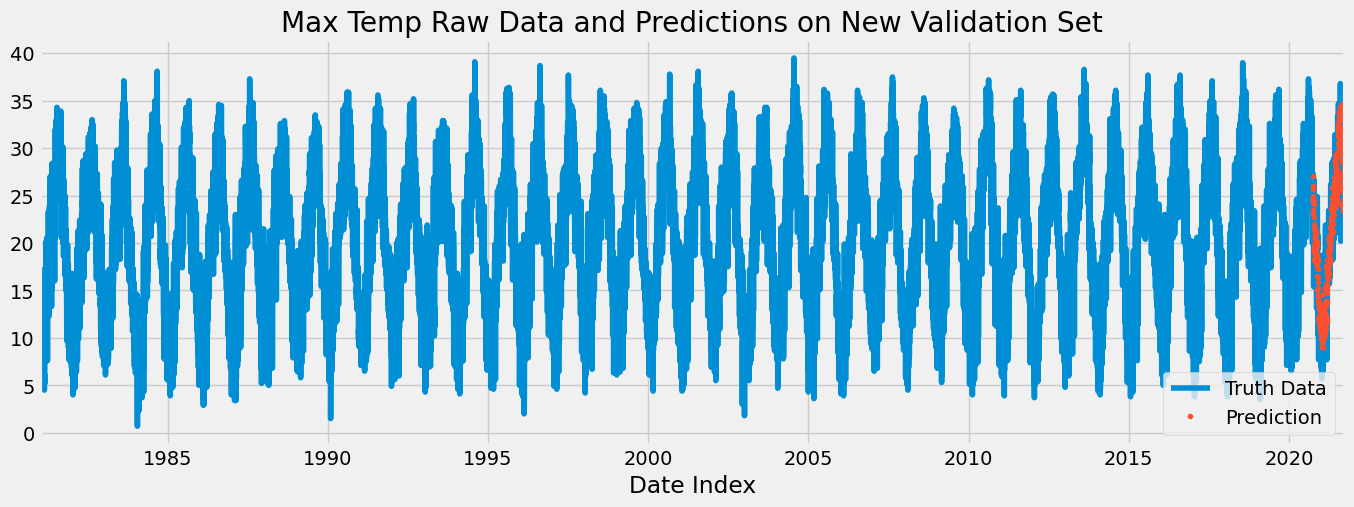

In [107]:
ax = df[['Max temp']].plot()
df['New Prediction_MAX'].plot(ax=ax, style='.')
plt.legend(['Truth Data','Prediction'])
ax.set_title('Max Temp Raw Data and Predictions on New Validation Set')
plt.show()

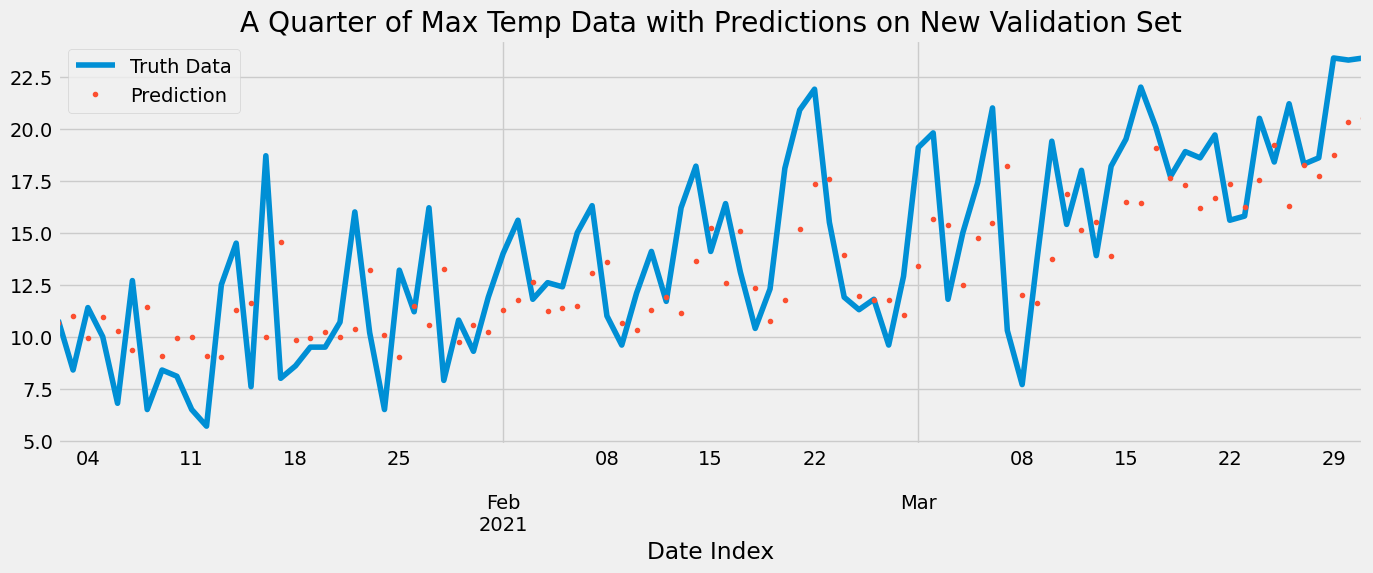

In [118]:
#plotting max temp data over a quarter w/ predictions
ax = df.loc[(df.index > '2021-01-01') & (df.index < '2021-04-01')]['Max temp']\
        .plot(title='A Quarter of Max Temp Data with Predictions on New Validation Set', style='-')
df.loc[(df.index > '2021-01-01') & (df.index < '2021-04-01')]['New Prediction_MAX'].plot(ax=ax,style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

<Axes: xlabel='Date Index'>

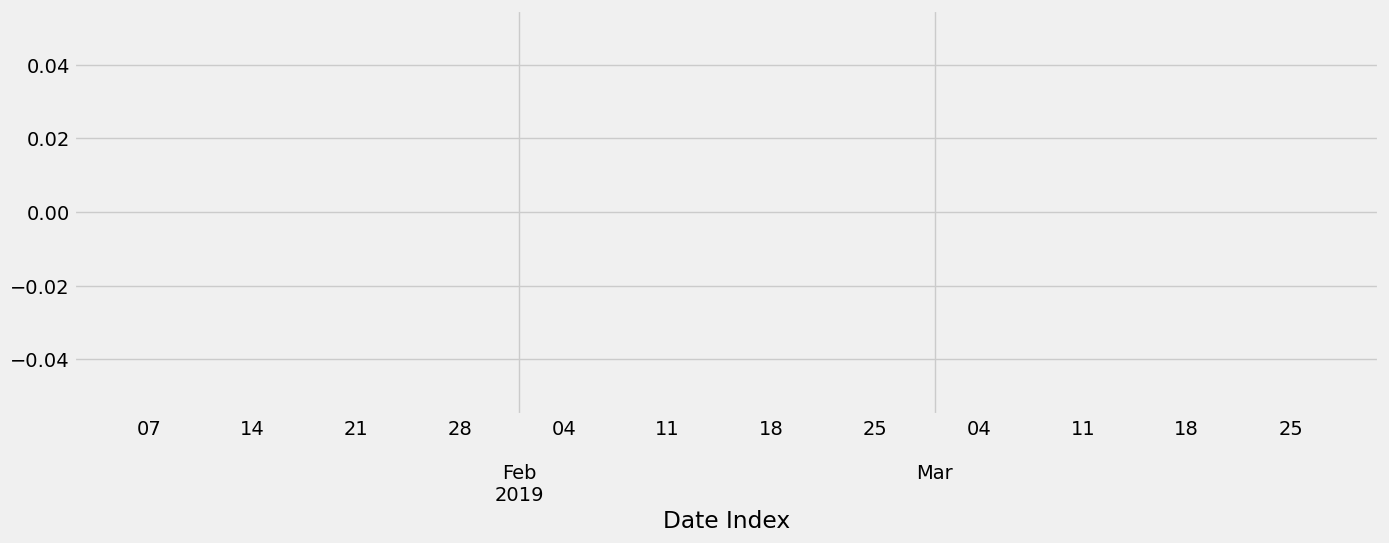

# Forecasting max temperatures with 5 folds and lag features - predict 3 years into the future

In [120]:
#the model seems good so for the forecasting we need to retrain on all of the data
FEATURES = ['Week','Month','Quarter','Year','lag_1_Max temp','lag_2_Max temp','lag_3_Max temp']
TARGET = 'Max temp'

X_all = df[FEATURES]
Y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000, 
                          early_stopping_rounds=50,
                          objective='reg:squarederror',
                          max_depth=3,
                          learning_rate=0.01)
reg.fit(X_all, Y_all,
       eval_set=[(X_all, Y_all)],
       verbose=100)

[0]	validation_0-rmse:21.07095
[100]	validation_0-rmse:8.23500
[200]	validation_0-rmse:4.05028
[300]	validation_0-rmse:3.02606
[400]	validation_0-rmse:2.83519
[500]	validation_0-rmse:2.79718
[600]	validation_0-rmse:2.78367
[700]	validation_0-rmse:2.77401
[800]	validation_0-rmse:2.76668
[900]	validation_0-rmse:2.75934
[999]	validation_0-rmse:2.75263


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [131]:
max_forecast = pd.date_range(start='2021-09-28', end='2024-09-28')
max_forecast_df = pd.DataFrame(index=max_forecast)
max_forecast_df['isFuture'] = True
max_forecast_df = create_features(max_forecast_df)
df['isFuture'] = False
df_and_forecast = pd.concat([df,max_forecast_df])
df_and_forecast

,Date,Rainfall,Ave temp,Max temp,Min temp,Snowfall,Max snow cover,Week,Month,Quarter,Year,Temp variation,Prediction_MAX,lag_1_Max temp,lag_2_Max temp,lag_3_Max temp,New Prediction_MAX,isFuture
1981-01-01,1981-01-01,0.0,5.0,8.9,1.3,0.0,0.0,1,1,1,1981,7.6,NaN,NaN,NaN,NaN,NaN,False
1981-01-02,1981-01-02,2.0,4.6,7.5,1.9,0.0,0.0,1,1,1,1981,5.6,NaN,8.9,NaN,NaN,NaN,False
1981-01-03,1981-01-03,0.0,5.1,9.0,2.2,0.0,0.0,1,1,1,1981,6.8,NaN,7.5,NaN,NaN,NaN,False
1981-01-04,1981-01-04,0.0,4.4,9.6,-0.6,0.0,0.0,1,1,1,1981,10.2,NaN,9.0,NaN,NaN,NaN,False
1981-01-05,1981-01-05,0.0,4.1,8.4,0.0,0.0,0.0,2,1,1,1981,8.4,NaN,9.6,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-24,NaT,NaN,NaN,NaN,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-09-25,NaT,NaN,NaN,NaN,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-09-26,NaT,NaN,NaN,NaN,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,NaN,True
2024-09-27,NaT,NaN,NaN,NaN,NaN,NaN,NaN,39,9,3,2024,NaN,NaN,NaN,NaN,NaN,NaN,True


# Average Temperature Outlier Analysis

In [ ]:
sns.boxplot(data=df,x='Year', y='Ave temp')
plt.title('Ave Temp by Year')
plt.ylabel('Temperature °C')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df['Ave temp'].hist()
plt.xlabel('Temperature')

# Ave temp train/test split

In [ ]:
#plotting a quarter of ave temp data
df.loc[(df.index > '2019-01-01') & (df.index < '2019-04-01')][['Ave temp']].plot(title='A Quarter of Ave Temp Data')
plt.legend('', frameon=False)
plt.show()

In [ ]:
fig, ax = plt.subplots()
train.plot(ax=ax, x='Date', y='Ave temp')
test.plot(ax=ax, x='Date', y='Ave temp')
ax.legend(['Training Set (1981-2018)','Test Set (2019-2021)'])
plt.show()

In [ ]:
sns.boxplot(data=df, x='Month', y='Ave temp')
plt.title('Ave Temperatures by Month')

# Regression model for average temp

In [ ]:
TARGET_AVE = 'Ave temp'
Y_test_AVE = test[TARGET_AVE]
Y_train_AVE = train[TARGET_AVE]

In [ ]:
reg_AVE = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate=0.01)
reg_AVE.fit(X_train, Y_train_AVE, 
       eval_set=[(X_train, Y_train_AVE), (X_test, Y_test_AVE)],
       verbose=50)

# Ave Temp Feature Importances

In [ ]:
fi_AVE = pd.DataFrame(data=reg_AVE.feature_importances_,
            index=reg_AVE.feature_names_in_,
            columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend('', frameon=False)
plt.show()

# Forecast on ave temp data

In [ ]:
test['Prediction_AVE'] = reg_AVE.predict(X_test)
df = df.merge(test['Prediction_AVE'], how='left', left_index=True, right_index=True)
df

In [ ]:
ax = df[['Ave temp']].plot()
df['Prediction_AVE'].plot(ax=ax, style='.')
plt.legend(['Truth Data','Prediction'])
ax.set_title('Ave Temp Raw Data and Predictions')
plt.show()

In [ ]:
#plotting a quarter of data w/ 
ax = df.loc[(df.index > '2019-01-01') & (df.index < '2019-04-01')]['Ave temp']\
        .plot(title='A Quarter of Ave Temp Data with Predictions', style='-')
df.loc[(df.index > '2019-01-01') & (df.index < '2019-04-01')]['Prediction_AVE'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()